# ***DSAA5020 Assignment 1: If Sanshui Needed in City Roadside Sites?***


---
### **50015627 JIANG Zhuoyang**
### Oct.11 2023



# 1.Task Description

## (1) Motivation:
"Shanshui City" was first proposed by Qian Xuesen in 1990 and is a futuristic urban concept based on traditional Chinese views of natural landscapes and the unity of heaven and humanity. However, compared to other contemporary theories of future cities at the time, Shanshui City was more of a conceptual idea. Research and exploration in this regard were limited, and a comprehensive set of ideas and feasible solutions to address modern urban issues were lacking.

With the development of urban planning as a discipline and China's economic growth, Chinese cities have gradually shifted from incremental expansion to stock optimization. Stock optimization has become a focal point of attention. Therefore, I have combined the mature technology of street-level imagery big data and the features of geographic information systems, such as massive data scale, rich information, and the unity of data subjectivity and objectivity, to reconsider Qian Xuesen's "Shanshui City" concept. My task is to utilize machine learning techniques to assess whether fine-grained urban plots require "Shanshui-like" development.

## (2) Task:
The nature of the task is to train a binary classification model based on machine learning. The model takes input in the form of feature vectors constructed from various types of information pertaining to specific urban roadside locations. The output is a binary label indicating whether the location is suitable for "Shanshui" development. A label of 1 signifies suitability, while a label of 0 indicates unsuitability.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import shuffle
from io import StringIO
import sys
sns.set_style('whitegrid')
%matplotlib inline

# 2. Dataset （CODE in Folder './DatasetConstruct'）
## (1) What kind Data do we need?
I believe that evaluating the potential for "Shanshui-like" development of a place requires consideration of two types of information:

1. Subjective perceptual information centered around human experiences.
2. Objective geographical information based on the overall urban development context.

The data sources for these two types of information need to correspond to their respective characteristics:

1. Street-level image data: This data can provide a fine-grained description of people's experiential perceptions in a given environment, making it human-centric. Additionally, due to the vast amount of data in street-level image datasets, batched street-level image data can also reflect the overall perceptual information of an entire location from a macro perspective.

2. Geographic information data (POI - Points of Interest): Some commonly used geographical information data have the potential to provide background information on urban development from the perspective of city services, population, and other aspects. This is also a crucial factor in determining whether an urban area can undergo "Shanshui-like" development.

## (2) How the data been collected?
Regarding these two types of data, I need to first obtain the coordinates of all street spaces in a specific research location, and then proceed with data collection in different ways, which can be broken down into the following steps:

1. Coordinate Point Information Retrieval:
   I obtained a table of geographic coordinates for all the streets in the city (Nanjing) from a colleague in urban planning. The approach to obtaining this information is as follows:
   - Use the Baidu Maps Snapshot Tool to capture the trajectories of Baidu Street View cars.
   - Vectorize and geographically align this map in ARCGIS, and discretize it at 50-meter intervals to obtain coordinates for each point along the street view trajectory (at 50-meter intervals).

2. Street View Image Information Retrieval:
   - Utilize the API key provided by the Baidu Maps Open Platform to batch retrieve street view images. Construct URLs using the latitude and longitude coordinates, API key, and other street view capture parameters.
   - Retrieve street view images at three different angles for each coordinate point: 45°, 90°, and 135° to ensure comprehensive information for each point. To ensure that the capture angle parameters are fixed on the right side of the street, it is necessary to label whether each geographic coordinate point is located on a one-way or two-way road. There are three types: one-way, two-way forward (check if it's northbound first and then eastbound), and two-way backward (check if it's southbound first and then westbound).
   - Batch retrieve street view images at these three angles.
   - Use a pre-trained ResnetPSP semantic segmentation model based on MXnet Model Zoo, trained on the cityscapes dataset, to perform semantic segmentation on all street view images at the three angles and calculate the weighted average of semantic feature proportions. Each semantic feature serves as a dimension in the feature vector (a total of 19 dimensions, located in feature vector positions 11-30).
   - Calculate six advanced semantic features based on professional formulas to extract advanced visual information for the coordinate points: GreenSpaceCompetitiveness, Publication, SkyViewFactor, GreenLookingRatio, Enclosure, PavementFeasibility. Each advanced semantic feature serves as a dimension in the feature vector (a total of 6 dimensions, located in feature vector positions 5-10).

3. Geographic Information Data Retrieval:
   Select several types of information from the POI data previously collected by urban planning colleagues that we need. Use the latitude and longitude of the coordinate points to combine the geographic information and street view image information into a single feature vector. The selected geographic information mainly includes five types: BusStationND, SubwayStationND, PubToiletND, CateringND, ConvenienceStoreND. Each geographic information feature serves as a dimension in the feature vector (a total of 5 dimensions, located in feature vector positions 0-4).

## (3) Feature Conclusion:
[0-4]BusStationND, SubwayStationND, PubToiletND, CateringND, ConvenienceStoreND.
[5-10]GreenSpaceCompetitiveness, Publication, SkyViewFactor, GreenLookingRatio, Enclosure, PavementFeasibility
[11-30]'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle'
## (4) Sample Selection and Data Annotation:
I use the equal-distance Sampling menthod to select 987 samples to construct Training Set.

Then,to manually annotate the coordinate points for the suitability of "Shanshui-like" development, you can use the following labeling scheme:

1. Suitable (labeled as 1) - This includes the following categories:
 - Areas suitable for adding aesthetic value - e.g., residential and working areas (residential buildings, schools, office buildings).
 - Areas that contribute to social value - e.g., public service facilities (hospitals).
 - Areas with the potential for economic value enhancement - e.g., commercial complexes (shopping malls, supermarkets, farmer's markets).

2. Not suitable (labeled as 0) - This includes several categories:
 - Facilities that are not easily reconstructed - e.g., transportation facilities (elevated highways, interchanges, tunnels).
 - Areas with significant cultural or historical value - e.g., urban park areas (historical preservation sites, centralized parks, pocket parks).

In [ ]:
# Specify the Excel file path to be read
file_path = "/content/IFShanshuiNeeded-Dataset.xls"
# Use the read_excel function from pandas to read the Excel file
df = pd.read_excel(file_path)


## (5) Data Preparation:
I use dataprepto do visualization which simplifies the creation of informative data visualizations. It offers a wide range of visualization options, including histograms, scatter plots, and bar charts, making it easier to explore and communicate insights from the data. The library provides a user-friendly interface with simple and intuitive functions, making it accessible to both data scientists and analysts with varying levels of expertise.

In [ ]:
# Use Dataprep to describe data in a comprehensive way
! pip install dataprep
from dataprep.eda import create_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.0/764.0 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 49.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.9 MB/s eta 0:00:00
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.24-cp310-cp310-linux_x86_64.whl size=1252692 sha256=e5d91f6b5e290

DataPrep Report
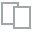
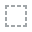
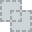
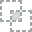
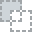
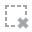
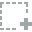
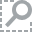
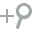
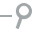
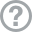
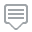
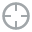
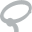
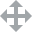
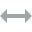
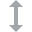
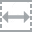
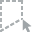
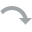
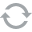
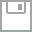
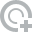
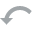
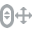
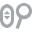
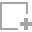
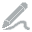
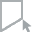
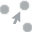
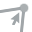
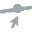

In [ ]:
create_report(df)

### Feature characteristics:
In the case of having image data, I first utilized semantic segmentation to manually extract semantic elements from the images as the foundational features. I then introduced advanced semantic information computed from a few related semantic elements as high-level features. Furthermore, I incorporated two-dimensional objective geographic information as a supplementary feature to enrich the feature vector with a three-dimensional subjective visual scene information (which is, in fact, a somewhat reluctant approach, as no matter how many features I summarize, they cannot fully approach the features unconsciously extracted by humans when perceiving environmental information).

Based on the feature analysis results generated using Dataprep, I can summarize the following key points:

1. The zero rate for geographic information data is relatively high, which has both advantages and disadvantages. On the positive side, the feature attributes of samples with non-zero values in this category stand out more, resulting in larger distances between different samples in the feature space, making them more distinguishable in classification. However, if this feature is overly sparse, its significance may be low.

2. The correlation between features is decent, but high-level features have not effectively linked the features. Perhaps a deep learning approach is needed to explore deeper features.

# 3. Data Processing

In [ ]:
# ML Dataset construct
# Target variable:
Y = df['label']
# Feature vector:
X = df.loc[:, ['BusStationND', 'SubwayStationND', 'PubToiletND', 'CateringND', 'ConvenienceStoreND', 'GreenSpaceCompetitiveness', 'Publication',
                'SkyViewFactor', 'GreenLookingRatio', 'Enclosure', 'PavementFeasibility',
                'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']]
X = pd.DataFrame(X)

# Check if the number of samples in X and Y match
assert X.shape[0] == Y.size


In [ ]:
# Check the number of rows and columns in the dataset
print('Number of samples in the dataset:', X.shape[0])
print('Number of features per sample:', X.shape[1])

# View the first 10 samples in the dataset
X.head(10)

Number of samples in the dataset: 987
Number of features per sample: 30


BusStationND  SubwayStationND  PubToiletND  CateringND  ConvenienceStoreND  \
0      0.012946         0.125749     0.040578    0.005614            0.023221   
1      0.145960         0.150409     0.011038    0.007192            0.028280   
2      0.698298         0.000000     0.017723    0.156722            0.068155   
3      0.147145         0.000000     0.124481    0.002207            0.000000   
4      0.368432         0.000000     0.000000    0.070646            0.000000   
5      0.461468         0.000000     0.033757    0.038161            0.006607   
6      0.470553         0.000000     0.037766    0.111428            0.088404   
7      0.410133         0.000000     0.122118    0.055117            0.009266   
8      0.405619         0.000000     0.067551    0.063022            0.128148   
9      0.292320         0.000000     0.000000    0.030734            0.080152   

   GreenSpaceCompetitiveness  Publication  SkyViewFactor  GreenLookingRatio  \
0                   0.560000     6448.780       0.261667           0.119444   
1                   0.567082     6448.780       0.171665           0.212198   
2                   1.000000     3168.096       0.055741           0.153368   
3                   0.522361     5219.020       0.207717           0.105420   
4                   0.868000     2932.148       0.062434           0.295856   
5                   0.796747     3475.292       0.173113           0.123800   
6                   0.904000    49660.588       0.112545           0.180856   
7                   0.694569     3006.080       0.066161           0.280014   
8                   0.929260     3168.096       0.039394           0.120523   
9                   0.818186     2250.900       0.101571           0.186094   

   Enclosure  ...   terrain       sky    person     rider       car     truck  \
0   0.250080  ...  0.032231  0.261667  0.003661  0.000000  0.039207  0.000000   
1   0.488257  ...  0.036488  0.171665  0.008674  0.000174  0.003925  0.000000   
2   1.409242  ...  0.052937  0.055741  0.009141  0.000000  0.048082  0.000000   
3   0.245801  ...  0.000000  0.207717  0.000257  0.000000  0.016179  0.000000   
4   0.618237  ...  0.016497  0.062434  0.006486  0.000000  0.015040  0.000000   
5   0.689167  ...  0.002295  0.173113  0.000000  0.000000  0.101611  0.000000   
6   0.622038  ...  0.000000  0.112545  0.002450  0.000000  0.068851  0.000000   
7   0.782734  ...  0.074674  0.066161  0.000153  0.000000  0.057642  0.000000   
8   1.184263  ...  0.004377  0.039394  0.018852  0.001646  0.065818  0.017955   
9   0.585337  ...  0.007398  0.101571  0.000259  0.000896  0.050260  0.012406   

        bus  train  motorcycle   bicycle  
0  0.000792    0.0    0.025762  0.000085  
1  0.001142    0.0    0.000000  0.034521  
2  0.000000    0.0    0.000000  0.001644  
3  0.000000    0.0    0.000000  0.000000  
4  0.000000    0.0    0.000000  0.006649  
5  0.000000    0.0    0.000000  0.000000  
6  0.017351    0.0    0.000000  0.009556  
7  0.000137    0.0    0.000144  0.000174  
8  0.000000    0.0    0.016033  0.021740  
9  0.000000    0.0    0.012031  0.000000  

[10 rows x 30 columns]

In [ ]:
# Standardize X
X_scaled = preprocessing.scale(X)
# Convert the data type to a DataFrame
X_scaled = pd.DataFrame(X_scaled)
# Print the summary statistics of the standardized data
X_scaled.describe()

0             1             2             3             4   \
count  9.870000e+02  9.870000e+02  9.870000e+02  9.870000e+02  9.870000e+02   
mean   1.619778e-16  4.319409e-17 -2.879606e-17 -1.151842e-16 -7.199015e-17   
std    1.000507e+00  1.000507e+00  1.000507e+00  1.000507e+00  1.000507e+00   
min   -1.113892e+00 -4.348712e-01 -6.745781e-01 -6.820946e-01 -6.821985e-01   
25%   -1.018796e+00 -4.348712e-01 -6.745781e-01 -6.682674e-01 -6.821985e-01   
50%   -6.870659e-02 -4.348712e-01 -4.928511e-01 -4.505819e-01 -4.573025e-01   
75%    6.020173e-01 -4.222252e-01  3.063532e-01  3.105160e-01  3.108070e-01   
max    4.375048e+00  5.670945e+00  5.881183e+00  5.695423e+00  6.162207e+00   

                 5             6             7             8             9   \
count  9.870000e+02  9.870000e+02  9.870000e+02  9.870000e+02  9.870000e+02   
mean   6.479113e-17  7.199015e-17 -1.079852e-17  1.223832e-16  1.259828e-17   
std    1.000507e+00  1.000507e+00  1.000507e+00  1.000507e+00  1.000507e+00   
min   -4.325005e+00 -5.586364e-01 -1.579261e+00 -1.440798e+00 -1.371863e-01   
25%   -5.879523e-01 -4.662744e-01 -8.206446e-01 -7.999796e-01 -9.153618e-02   
50%    4.181555e-01 -2.211999e-01 -4.432321e-02 -1.449407e-01 -6.547347e-02   
75%    8.122028e-01  1.767983e-01  7.543494e-01  6.561805e-01 -3.315316e-02   
max    8.122028e-01  1.001400e+01  3.276350e+00  3.603916e+00  2.898690e+01   

       ...            20            21            22            23  \
count  ...  9.870000e+02  9.870000e+02  9.870000e+02  9.870000e+02   
mean   ...  8.638817e-17 -1.079852e-17  5.399261e-17 -2.699630e-17   
std    ...  1.000507e+00  1.000507e+00  1.000507e+00  1.000507e+00   
min    ... -7.284871e-01 -1.579261e+00 -4.106531e-01 -2.341743e-01   
25%    ... -6.725052e-01 -8.206446e-01 -3.878386e-01 -2.341743e-01   
50%    ... -3.600621e-01 -4.432321e-02 -2.903201e-01 -2.341743e-01   
75%    ...  3.414744e-01  7.543494e-01 -1.898729e-02 -1.944402e-01   
max    ...  7.364355e+00  3.276350e+00  1.417574e+01  1.322454e+01   

                 24          25            26            27            28  \
count  9.870000e+02  987.000000  9.870000e+02  9.870000e+02  9.870000e+02   
mean  -2.879606e-17    0.000000 -5.039310e-17  1.439803e-17  1.799754e-18   
std    1.000507e+00    1.000507  1.000507e+00  1.000507e+00  1.000507e+00   
min   -8.526456e-01   -0.154019 -1.296375e-01 -5.862397e-02 -2.939395e-01   
25%   -6.358736e-01   -0.154019 -1.296375e-01 -5.862397e-02 -2.939395e-01   
50%   -2.585282e-01   -0.154019 -1.296375e-01 -5.862397e-02 -2.939395e-01   
75%    3.292515e-01   -0.154019 -1.296375e-01 -5.862397e-02 -1.716267e-01   
max    1.098081e+01   19.372883  1.991145e+01  2.677887e+01  1.462661e+01   

                 29  
count  9.870000e+02  
mean  -3.959458e-17  
std    1.000507e+00  
min   -4.267247e-01  
25%   -4.267247e-01  
50%   -3.238333e-01  
75%    1.347522e-02  
max    1.386303e+01  

[8 rows x 30 columns]

In [ ]:
# Import the necessary module for train-test splitting
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Split the dataset into training and testing sets
# x_train: Training feature data
# x_test: Testing feature data
# y_train: Training target data
# y_test: Testing target data
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, random_state=40, test_size=0.1)

# Create a PCA (Principal Component Analysis) object with specified settings
pca = PCA(n_components=30, whiten=True, random_state=42)

# 4. Model Training
I choose SVM to do the Classification Task

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score

In [ ]:
# Create a Support Vector Classifier (SVC) object with the 'rbf' kernel and balanced class weights
svc = SVC(kernel='rbf', class_weight='balanced')

# Create a pipeline that first applies PCA and then uses SVC for classification
model = make_pipeline(pca, svc)

# Train the model
model.fit(x_train,y_train)

Pipeline(steps=[('pca', PCA(n_components=30, random_state=42, whiten=True)),
                ('svc', SVC(class_weight='balanced'))])

In [ ]:
from sklearn.metrics import classification_report
# Calculate the accuracy score on the training set
acu_train = model.score(x_train, y_train)
# Calculate the accuracy score on the testing set
acu_test = model.score(x_test, y_test)
# Print the accuracy
print("Training Accuracy: {:.2f}%".format(100 * acu_train))
print("Testing Accuracy: {:.2f}%".format(100 * acu_test))

# Calculate the recall score on the testing set using the macro-average method
y_pred = model.predict(x_test)
recall = recall_score(y_test, y_pred, average="macro")

print(classification_report(y_test, y_pred))

Training Accuracy: 75.79%
Testing Accuracy: 73.74%
              precision    recall  f1-score   support

           0       0.50      0.35      0.41        26
           1       0.79      0.88      0.83        73

    accuracy                           0.74        99
   macro avg       0.65      0.61      0.62        99
weighted avg       0.71      0.74      0.72        99



# 5.Conclusion:
From the ML task below, I have conclude some task-ablout expierience and task-after motivations, especially below:
### (1) From Bi-Shanshui to Multi-Shanshui:
In my binary classification task, I have assessed the proposition of whether an area is landscaped or not. However, I wish to further elaborate on the directions of landscaping development, which should be done in two steps:

1. From binary classification to multi-classification. This requires me to spend more time annotating data for multi-class classification based on domain knowledge. I have already established the following categories based on domain knowledge:

  Task: Classification of the development direction of individual coordinate points in the city streets.
  Output: Five categories:

  - 1.Restore Cultural Value - Examples: Urban park sites (cultural heritage sites, centralized parks, pocket parks).

  - 2.Deepen Economic Value - Examples: Commercial complexes (malls, supermarkets, farmers' markets).

  - 3.Enhance Ecological Value - Examples: Transportation facilities (elevated bridges, overpasses, tunnels).

  - 4.Maintain Social Value - Examples: Public service facilities (hospitals).

  - 5.Add Aesthetic Value - Examples: Residential and work areas (residential buildings, schools, office buildings).
  Input: Feature vectors obtained from various POI data for each location.

2. From multi-classification to parallel task evaluation or multi-task evaluation. This requires me to restructure the model architecture, either training five parallel models or training a complex model based on multi-task learning methods.

### (2) Subjective or Objective?
Next, I combined the requirements of subjective and objective elements for the "If Shanshui-like" task and analyzed the advantages and limitations of data input in terms of subjectivity and objectivity. This is a crucial factor contributing to our less-than-optimal accuracy.

I used the semantic segmentation results of street view images, specifically the proportions of semantic elements, as several dimensions of the feature vector. From these dimensions, I selected certain semantic elements for the computation of advanced semantic features, creating additional feature dimensions, thereby linking some of the semantic elements to introduce subjective visual information into the features. Additionally, I introduced POI (Point of Interest) geographic information to construct several feature dimensions, thus incorporating objective geographic information into the features. This approach has its advantages and disadvantages:

**Advantages:**

1. **Integration of Subjective and Objective Information:** By using semantic segmentation results for feature vector construction, you introduce subjective visual information into the features. This can help the model better understand the semantic information in the images, improving content understanding.

2. **Diverse Features:** Using multiple semantic elements and POI geographic information as features provides more information about the images. This enriches the feature space, allowing the model to better capture different types of image information.

3. **Reduced Overfitting:** Introducing multiple feature dimensions can reduce the risk of model overfitting, as the model no longer relies solely on pixel-level information but makes decisions based on higher-level semantic and geographic information.

4. **Improved Localization:** Using POI geographic information can help the model more accurately locate objects or scenes in the images. This is valuable for tasks requiring spatial awareness, such as navigation or location.

**Disadvantages:**

1. **Complexity:** Introducing more feature dimensions increases the complexity of the model, which may require more computational resources and data for training and tuning. Complexity raises development and maintenance costs.

2. **Feature Selection and Maintenance:** Careful selection of which semantic elements and geographic information to use as features is necessary. Inappropriate choices may introduce noise or redundant information, affecting model performance.

3. **Feature Generation Costs:** Semantic segmentation and POI geographic information annotation may incur time costs. This can limit the available data volume and frequency.

4. **Generalization Challenges:** The model's generalization capability may be limited by the specific semantic elements and geographic information selected. For tasks unrelated to the chosen elements, the model may perform poorly.

5. **Data Consistency:** Semantic segmentation results and POI information for street view images may vary with time and location. This can lead to differences in model performance in different environments.

### (3) Deep Learning or Classical Machine Learning?
In summary, this approach essentially reflects the limitations of traditional machine learning feature engineering. Given the availability of image data, I initially used semantic segmentation to manually extract features from the images and then introduced additional features to enrich the feature vectors. This can be seen as a somewhat reluctant solution. No matter how many features I summarize, it cannot fully approximate the features unconsciously captured when humans perceive environmental information subjectively. Moreover, the process of feature engineering is time-consuming and labor-intensive. If I want to use my model on new raw data (street-view images), I still need to preprocess it into semantic data.

The advantage of deep learning, on the other hand, lies in the following:

1. **No Need for Manual Feature Engineering**: Deep learning can automatically extract more abstract features through automated feature extraction. While interpretability may decrease, the overall performance is undoubtedly superior.

2. **Direct Input of Raw Data**: Key operations like image convolution allow direct input of raw data to extract high-level features, saving data preprocessing costs.

3. **Maturity of Pre-trained Models**: There are now many highly mature pre-trained models for image tasks, especially the EfficientNet series, known for their excellent generalization capabilities and manageable size. These models can serve as a solid backbone for tasks like the one I'm working on.


**All in all, data is always a critical component in the realm of machine learning for application-based tasks. Once I've established a stable data pipeline, I can further complicate the tasks. However, this introduces two types of challenges: one concerning the model's capacity and the other related to the difficulty of data annotation. The former can be addressed by introducing the backbone network of pre-trained deep learning models, while the latter requires substantial domain knowledge and interaction with experts from various domains.**
